This is a duplicate of Cullan's notebook by the same name, so that I can run it without messing with his.

Code to read in Kelly's base TF catalog, and convert it to a clustering catalog by cross-matching with the BGS clustering catalog, attaching weights and then returning a subset of the columns.

In [1]:
import fitsio
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from astropy.io import fits
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
from astropy.cosmology import FlatLambdaCDM
import matplotlib.colors as colors
from collections import namedtuple

LightSpeed = 299792.458
zmin = 0.01        # minimum redshift for selection
zmax = 0.1         # maximum redshift for selection
ngrid = 128        # grid size for number density
nzbin = 36         # number of redshift bins for plotting
rsets = 18         # number of DESI random catalogues to use
survey_area = 7739.58 * (np.pi/180.0)**2
cosmo = FlatLambdaCDM(H0=100.0,Om0=0.3151)
deccel = 3.0*0.3151/2.0 - 1.0

In [2]:
# Useful utilities
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def weighted_avg_and_std(values, weights, axis=None):
    average = np.average(values, weights=weights, axis=axis)
    average_err = np.std(values)*np.sqrt(np.sum((weights/np.sum(weights))**2))
    variance = np.average((values-average)**2, weights=weights, axis=axis)
    return (average, average_err, np.sqrt(variance))

def view_fields(a, names):
    """
    `a` must be a numpy structured array.
    `names` is the collection of field names to keep.

    Returns a view of the array `a` (not a copy).
    """
    dt = a.dtype
    formats = [dt.fields[name][0] for name in names]
    offsets = [dt.fields[name][1] for name in names]
    itemsize = a.dtype.itemsize
    newdt = np.dtype(dict(names=names,
                          formats=formats,
                          offsets=offsets,
                          itemsize=itemsize))
    b = a.view(newdt)
    return b

def remove_fields(a, names):
    """
    `a` must be a numpy structured array.
    `names` is the collection of field names to remove.

    Returns a view of the array `a` (not a copy).
    """
    dt = a.dtype
    keep_names = [name for name in dt.names if name not in names]
    return view_fields(a, keep_names)

# Heliocentric to CMB frame conversion routine from Anthony Carr.
def perform_corr(z_inp, RA, Dec, corrtype="full", dipole="Planck"):

    """
    A function to perform heliocentric corrections on redshifts.

    
    Inputs
    ======
    
    z_inp : float
        input heliocentric or CMB frame redshift
    
    RA : float
        equatorial right ascension
    
    Dec : float
        equatorial declination
    
    corrtype : string
        The type of correction to be performed. Either 'full' (default), 
        'approx',
        
        '-full' or '-approx', respectively corresponding to the proper 
        correction, low-z additive approximation, and the backwards corrections 
        to go from z_CMB to z_helio.
    
    dipole : string
        'Planck', 'COBE' or 'Astropy' dipoles. 'Astropy' imports astropy (slow) 
        and uses their co-ordinates and transforms and COBE dipole; different 
        beyond first decimal point.

    
    Outputs
    =======
    
    z_CMB : float
        (if corrtype is 'full' or 'approx')
    
    z_helio : float
        (only if corrtype is '-full' or '-approx')


    Notes
    =====
    
    Co-ords of North Galactic Pole (ICRS): 
        RA = 192.729 ± 0.035 deg, Dec = 27.084 ± 0.023 deg 
        (https://doi.org/10.1093/mnras/stw2772)
    
    Co-ords of Galactic Centre (ICRS): 
        RA = 17h45m40.0409s, Dec = −29d00m28.118s (see above reference)
        RA = 266.41683708 deg, Dec = -29.00781056 deg
    
    Ascending node of the galactic plane 
        = arccos(sin(Dec_GC)*cos(Dec_NGP)-cos(Dec_GC)*sin(Dec_NGP)*cos(RA_NGP-RA_GC))
        = 122.92828126730255 
        = l_0
    
    Transform CMB dipole from (l,b) to (RA,Dec):
        Dec = arcsin(sin(Dec_NGP)*sin(b)+cos(Dec_NGP)*cos(b)*cos(l_0-l))
            = -6.9895105228347 deg
        RA = RA_NGP + arctan((cos(b)*sin(l_0-l)) / (cos(Dec_NGP)*sin(b)-sin(Dec_NGP)*cos(b)*cos(l_0-l)))
            = 167.81671014708002 deg
    
    Astropy co-ordinates:
        RA_NGP_J2000 = 192.8594812065348, Dec_NGP_J2000 = 27.12825118085622, which are converted from B1950
        RA_NGP_B1950 = 192.25, Dec_NGP_B1950 = 27.4
        l_0_B1950 = 123
        l_0_J2000 = 122.9319185680026
    """

    v_Sun_Planck = 369.82  # +/- 0.11 km/s
    l_dipole_Planck = 264.021  # +/- 0.011 deg
    b_dipole_Planck = 48.253  # +/- 0.005 deg
    c = 299792.458  # km/s
    v_Sun_COBE = 371.0
    l_dipole_COBE = 264.14
    b_dipole_COBE = 48.26

    RA_Sun_Planck = 167.81671014708002  # deg
    Dec_Sun_Planck = -6.9895105228347
    RA_Sun_COBE = 167.88112630619747  # deg
    Dec_Sun_COBE = -7.024553155965497

    # RA_Sun_COBE = 168.01187366045565  # deg using Astropy values     # 168.0118667
    # Dec_Sun_COBE = -6.983037861854297  # # # -6.98303424

    if corrtype not in ["full", "approx", "-full", "-approx"]:
        print("Correction type unknown.")
        raise ValueError

    rad = np.pi / 180.0
    if dipole == "Planck":
        # Vincenty formula
        alpha = np.arctan2(
            np.hypot(
                np.cos(Dec_Sun_Planck * rad) * np.sin(np.fabs(RA - RA_Sun_Planck) * rad),
                np.cos(Dec * rad) * np.sin(Dec_Sun_Planck * rad)
                - np.sin(Dec * rad)
                * np.cos(Dec_Sun_Planck * rad)
                * np.cos(np.fabs(RA - RA_Sun_Planck) * rad),
            ),
            np.sin(Dec * rad) * np.sin(Dec_Sun_Planck * rad)
            + np.cos(Dec * rad)
            * np.cos(Dec_Sun_Planck * rad)
            * np.cos(np.fabs((RA - RA_Sun_Planck)) * rad),
        )
    elif dipole == "COBE":
        alpha = np.arctan2(
            np.hypot(
                np.cos(Dec_Sun_COBE * rad) * np.sin(np.fabs(RA - RA_Sun_COBE) * rad),
                np.cos(Dec * rad) * np.sin(Dec_Sun_COBE * rad)
                - np.sin(Dec * rad)
                * np.cos(Dec_Sun_COBE * rad)
                * np.cos(np.fabs(RA - RA_Sun_COBE) * rad),
            ),
            np.sin(Dec * rad) * np.sin(Dec_Sun_COBE * rad)
            + np.cos(Dec * rad)
            * np.cos(Dec_Sun_COBE * rad)
            * np.cos(np.fabs((RA - RA_Sun_COBE)) * rad),
        )
    elif dipole == "astropy":
        coord_helio_COBE = SkyCoord(l_dipole_COBE * u.degree, 
                                    b_dipole_COBE * u.degree, 
                                    frame="galactic").galactic
        coord = SkyCoord(RA * u.degree, Dec * u.degree, frame="icrs").galactic
        alpha = coord_helio_COBE.separation(coord).radian
    
    if dipole == "Planck":
        v_Sun_proj = v_Sun_Planck * np.cos(alpha)
    elif dipole in ["COBE", "astropy"]:
        v_Sun_proj = v_Sun_COBE * np.cos(alpha)

    # z_Sun = -v_Sun_proj / c
    # Full special rel. correction since it is a peculiar vel
    #z_Sun = np.sqrt((1.0 + (-v_Sun_proj) / c) / (1.0 - (-v_Sun_proj) / c)) - 1.0
    z_Sun = -v_Sun_proj/c

    min_z = 0.0
    if corrtype == "full":
        z_CMB = np.where(z_inp <= min_z, z_inp, (1 + z_inp) / (1 + z_Sun) - 1)
    elif (corrtype == "-full"):
        # backwards correction where z_CMB is actually z_helio and vice versa
        z_helio = np.where(z_inp <= min_z, z_inp, (1 + z_inp) * (1 + z_Sun) - 1)
    elif corrtype == "approx":
        z_CMB = np.where(z_inp <= min_z, z_inp, z_inp - z_Sun)
    elif corrtype == "-approx":
        z_helio = np.where(z_inp <= min_z, z_inp,  z_inp + z_Sun)

    if corrtype[0] == "-":
        return z_helio
    else:
        return z_CMB

def reweight(x, err, central="mean"):

    weight = 1.0 / err**2
    meanx = np.sum(x)/len(x)
    lamb = (np.sum(x*weight) - meanx*np.sum(weight))/(np.sum(x**2) - len(x)*meanx**2)
    newweight = weight - lamb*(x - meanx)
    newerr = np.sqrt(1.0/newweight)

    if central == "mean":
        return newerr - np.mean(newerr) + np.mean(err)
    else:
        return newerr - np.median(newerr) + np.median(err)

# Define a named tuple for the result, similar to SciPy's KstestResult
WeightedKstestResult = namedtuple('WeightedKstestResult', ['statistic', 'pvalue'])

def weighted_ks_2samp(data1, data2, weights1, weights2, alternative='two-sided', n_permutations=1000):
    """
    Performs a two-sample weighted Kolmogorov-Smirnov test, including p-value
    calculation via permutation testing.

    This function calculates the maximum difference between the weighted empirical
    cumulative distribution functions (WECDFs) of two samples. The p-value is
    estimated by repeatedly shuffling the data and weights between the two samples
    and re-calculating the test statistic.

    Parameters
    ----------
    data1 : array_like
        Observations from the first sample.
    data2 : array_like
        Observations from the second sample.
    weights1 : array_like
        Weights corresponding to observations in `data1`. Must have the same
        shape as `data1`.
    weights2 : array_like
        Weights corresponding to observations in `data2`. Must have the same
        shape as `data2`.
    alternative : {'two-sided', 'less', 'greater'}, optional
        Defines the null and alternative hypotheses.
        The following options are available (default is 'two-sided'):
        * 'two-sided': The null hypothesis is that the two distributions are
          identical, and the alternative is that they are not identical.
        * 'less': The null hypothesis is that F(x) >= G(x) for all x,
          where F and G are the (weighted) CDFs of `data1` and `data2`
          respectively. The alternative is that F(x) < G(x) for at least one x.
        * 'greater': The null hypothesis is that F(x) <= G(x) for all x.
          The alternative is that F(x) > G(x) for at least one x.
    n_permutations : int, optional
        The number of permutations to perform for p-value estimation.
        A higher number provides a more accurate p-value but increases
        computation time. Default is 1000. If 0 or less, p-value will be None.

    Returns
    -------
    result : WeightedKstestResult
        An object containing attributes:
        statistic : float
            The weighted KS test statistic.
        pvalue : float or None
            The estimated p-value from the permutation test. Will be None if
            `n_permutations` is 0 or less.

    Raises
    ------
    ValueError
        If `data` and `weights` arrays have different lengths, or if
        `alternative` is not one of the allowed options.
    """
    data1 = np.asarray(data1, dtype=float)
    data2 = np.asarray(data2, dtype=float)
    weights1 = np.asarray(weights1, dtype=float)
    weights2 = np.asarray(weights2, dtype=float)

    if data1.shape != weights1.shape:
        raise ValueError("data1 and weights1 must have the same shape.")
    if data2.shape != weights2.shape:
        raise ValueError("data2 and weights2 must have the same shape.")

    # Remove any NaN values (and their corresponding weights)
    valid_mask1 = ~np.isnan(data1)
    data1 = data1[valid_mask1]
    weights1 = weights1[valid_mask1]

    valid_mask2 = ~np.isnan(data2)
    data2 = data2[valid_mask2]
    weights2 = weights2[valid_mask2]

    # Helper function to calculate the weighted KS statistic
    def _calculate_weighted_ks_statistic(d1, d2, w1, w2, alt):
        # Sort data and corresponding weights by data value
        idx1 = np.argsort(d1)
        d1_sorted = d1[idx1]
        w1_sorted = w1[idx1]

        idx2 = np.argsort(d2)
        d2_sorted = d2[idx2]
        w2_sorted = w2[idx2]

        # Normalize weights so they sum to 1 for each sample
        sum_w1 = np.sum(w1_sorted)
        sum_w2 = np.sum(w2_sorted)

        if sum_w1 == 0 or sum_w2 == 0:
            return 0.0 # Return 0 statistic if no valid weights/data

        w1_normalized = w1_sorted / sum_w1
        w2_normalized = w2_sorted / sum_w2

        # Calculate the cumulative sums of normalized weights (WECDFs)
        wecdf1 = np.cumsum(w1_normalized)
        wecdf2 = np.cumsum(w2_normalized)

        # Combine all unique data points from both samples to evaluate the WECDFs
        all_data_points = np.unique(np.concatenate((d1_sorted, d2_sorted)))

        # Evaluate WECDFs at all combined data points using interpolation
        wecdf1_at_points = np.interp(all_data_points, d1_sorted, wecdf1, left=0.0, right=1.0)
        wecdf2_at_points = np.interp(all_data_points, d2_sorted, wecdf2, left=0.0, right=1.0)

        # Calculate the differences between the WECDFs
        differences = wecdf1_at_points - wecdf2_at_points

        # Determine the KS statistic based on the alternative hypothesis
        if alt == 'two-sided':
            return np.max(np.abs(differences))
        elif alt == 'less':
            return -np.min(differences) # D- = sup_x (G_n(x) - F_m(x)) = -inf_x (F_m(x) - G_n(x))
        elif alt == 'greater':
            return np.max(differences) # D+ = sup_x (F_m(x) - G_n(x))
        else:
            raise ValueError("`alternative` must be 'two-sided', 'less', or 'greater'.")

    # Calculate the observed statistic
    observed_statistic = _calculate_weighted_ks_statistic(data1, data2, weights1, weights2, alternative)

    pvalue = None
    if n_permutations > 0:
        # Prepare for permutation test
        combined_data = np.concatenate((data1, data2))
        combined_weights = np.concatenate((weights1, weights2))
        # Create labels to distinguish original samples (0 for data1, 1 for data2)
        original_labels = np.array([0] * len(data1) + [1] * len(data2))

        permuted_statistics = []
        for _ in range(n_permutations):
            # Shuffle the labels
            shuffled_indices = np.random.permutation(len(combined_data))
            permuted_labels = original_labels[shuffled_indices]

            # Reconstruct permuted samples based on shuffled labels
            perm_data1 = combined_data[permuted_labels == 0]
            perm_weights1 = combined_weights[permuted_labels == 0]
            perm_data2 = combined_data[permuted_labels == 1]
            perm_weights2 = combined_weights[permuted_labels == 1]

            # Calculate statistic for permuted samples
            # Ensure permuted samples are not empty before calculating statistic
            if len(perm_data1) > 0 and len(perm_data2) > 0:
                stat = _calculate_weighted_ks_statistic(perm_data1, perm_data2, perm_weights1, perm_weights2, alternative)
                permuted_statistics.append(stat)
            else:
                # If a permuted sample is empty, the statistic is 0 (no difference)
                permuted_statistics.append(0.0)

        # Calculate p-value: proportion of permuted statistics >= observed statistic
        # Add 1 to numerator and denominator for a more robust estimate (avoids p=0)
        pvalue = (np.sum(np.array(permuted_statistics) >= observed_statistic) + 1) / (n_permutations + 1)

    return WeightedKstestResult(statistic=observed_statistic, pvalue=pvalue)



In [3]:
# Read in the TF full file
hdul = fits.open("/global/cfs/cdirs/desicollab/science/td/pv/tfgalaxies/Y1/DESI-DR1_TF_pv_cat_v10.fits")
data_TF_full = pd.DataFrame(fitsio.read("/global/cfs/cdirs/desicollab/science/td/pv/tfgalaxies/Y1/DESI-DR1_TF_pv_cat_v10.fits").byteswap().newbyteorder())
data_TF_full["SGA_ID"] = data_TF_full["SGA_ID"].astype(np.int64)
data_TF_full["zcmb"] = data_TF_full["Z_DESI_CMB"]
data_TF_full = data_TF_full.drop(data_TF_full[(data_TF_full["DWARF"] == 1) | (data_TF_full["zcmb"] < 0.0033) | (data_TF_full["zcmb"] > 0.1)].index)
data_TF_full["MU"] = data_TF_full["MU_TF"]
data_TF_full["MU_ERR"] = np.sqrt(data_TF_full["MU_TF_ERR"]**2 + hdul[0].header["SIG"]**2)
data_TF_full["LOGDIST"] = np.log10(cosmo.comoving_distance(data_TF_full["zcmb"]).value) + np.log10(1 + data_TF_full["Z_DESI"]) - data_TF_full["MU"]/5.0 + 5.0
data_TF_full["LOGDIST_ERR"] = data_TF_full["MU_ERR"]/5.0
#data_TF_full["logdist_gauss_err"] = reweight(data_TF_full["LOGDIST"], data_TF_full["LOGDIST_ERR"], central="median")
data_TF_full["logdist_gauss_err"] = data_TF_full["LOGDIST_ERR"]

# Read in the FP full file
data_FP_full = pd.read_csv("/global/cfs/cdirs/desi/science/td/pv/fpgalaxies/Y1/v4/FP_pv_cat_v4.csv", usecols=['targetid', 'survey', 'program', 'healpix', 'ra', 'dec', 'r', 'er', 's', 'es', 'i', 'ei', 'circ_radius', 'circ_radius_err', 'z', 'zcmb', 'logdist', 'logdist_err', 'logdist_nmc', 'logdist_err_nmc', 'primaryVdisp', 'FPcalibrator'])
#print(data_FP_full[data_FP_full["targetid"] == 39627673764365361])
data_FP_full["logdist_gauss_err"] = reweight(data_FP_full["logdist"], data_FP_full["logdist_err"])
data_FP_full = data_FP_full.drop(data_FP_full[data_FP_full["FPcalibrator"] == 0].index)
data_FP_full["LOGDIST"] = data_FP_full["logdist"]
data_FP_full["MU"] = 5.0 * (np.log10(cosmo.comoving_distance(data_FP_full["zcmb"]).value) + np.log10(1 + data_FP_full["z"]) - data_FP_full["logdist"]) + 25.0
#data_FP_full["logdist_gauss_err"] = data_FP_full["logdist_err"]

#plt.hist(data_FP_full["logdist_err"], bins=31, range=[0.09, 0.20], ec='r', fc='None', label="FP data", alpha=1.0)
#plt.hist(data_FP_full["logdist_gauss_err"], bins=31, range=[0.09, 0.20], ec='r', fc='r', label="FP data, Gaussianised", alpha=0.5)
#plt.hist(data_TF_full["LOGDIST_ERR"], bins=31, range=[0.09, 0.20], ec='b', fc='None', label="TF data", alpha=1.0)
#plt.hist(data_TF_full["logdist_gauss_err"], bins=31, range=[0.09, 0.20], ec='b', fc='b', label="TF data, Gaussianised", alpha=0.5)
#plt.xlabel(r'$\sigma_{\eta}$')
#plt.xlim(0.09, 0.20)
#plt.legend();
#plt.show();

data_TF_full["LOGDIST_ERR"] = data_TF_full["logdist_gauss_err"]
data_TF_full["MU_ERR"] = 5.0*data_TF_full["logdist_gauss_err"]

data_FP_full["MU_ERR"] = 5.0*data_FP_full["logdist_gauss_err"]
data_FP_full["LOGDIST_ERR"] = data_FP_full["logdist_gauss_err"]

print(np.mean(data_FP_full["MU_ERR"]), np.mean(data_FP_full["LOGDIST_ERR"]))

0.5773478166593986 0.11546956333187972


In [4]:
# Read in the TF clustering file
data_TF = pd.DataFrame(fitsio.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/TF_clustering_data.fits').byteswap().newbyteorder())
data_TF["zcmb"] = perform_corr(data_TF["Z"], data_TF["RA"], data_TF["DEC"])  # redshifts in the clustering files come from BGS data files and are barycentric. We'll assume this is close enough to heliocentric  
data_TF["LOGDIST"] = np.log10(cosmo.comoving_distance(data_TF["zcmb"]).value) + np.log10(1 + data_TF["Z"]) - data_TF["MU"]/5.0 + 5.0
data_TF["LOGDIST_ERR"] = data_TF["MU_ERR"]/5.0

# Read in the FP clustering file
data_FP = pd.DataFrame(fitsio.read('/global/cfs/cdirs/desi/science/td/pv/fpgalaxies/Y1/v4/FP_clustering_data_v4.fits').byteswap().newbyteorder())
data_FP["zcmb"] = perform_corr(data_FP["Z"], data_FP["RA"], data_FP["DEC"])  # redshifts in the clustering files come from BGS data files and are barycentric. We'll assume this is close enough to heliocentric
data_FP["MU"] = 5.0 * (np.log10(cosmo.comoving_distance(data_FP["zcmb"]).value) + np.log10(1 + data_FP["Z"]) - data_FP["LOGDIST"]) + 25.0
data_FP["MU_ERR"] = 5.0*data_FP["LOGDIST_ERR"]

# Read in the random files
rand_TF20 = pd.DataFrame(fitsio.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/TF_clustering_random20.fits').byteswap().newbyteorder())
rand_FP20 = pd.DataFrame(fitsio.read('/global/cfs/cdirs/desi/science/td/pv/fpgalaxies/Y1/v4/FP_clustering_random20_v4.fits').byteswap().newbyteorder())
rand_TF200 = pd.DataFrame(fitsio.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/TF_clustering_random200.fits').byteswap().newbyteorder())
rand_FP200 = pd.DataFrame(fitsio.read('/global/cfs/cdirs/desi/science/td/pv/fpgalaxies/Y1/v4/FP_clustering_random200_v4.fits').byteswap().newbyteorder())

In [6]:
# FP and TF lookup table that gives the Lim 2017 groups. Contains individual TF and FP dist mods and also group-average dist mods for TF and FP.
lookup = pd.read_csv("/global/cfs/cdirs/desi/science/td/pv/combinedpv/PVsample_group_lookup+SNe.csv", 
                     usecols=["ID", "zcmb_gr", "group", "LOGDIST_FP", "LOGDIST_FP_ERR", "LOGDIST_TF", "LOGDIST_TF_ERR", "LOGDIST_DESI", "LOGDIST_DESI_ERR", "LOGDIST_SN", "LOGDIST_SN_ERR"])
lookup_unique = lookup[(lookup["LOGDIST_FP"] != 0.0) & (lookup["LOGDIST_TF"] != 0.0) & ~lookup.duplicated(subset="group", keep="first") & (lookup["zcmb_gr"] > 0.02) & (lookup["zcmb_gr"] < 0.09)]
lookup_either = lookup[((lookup["LOGDIST_FP"] != 0.0) | (lookup["LOGDIST_TF"] != 0.0)) & ~lookup.duplicated(subset="group", keep="first")]
lookup_desi = lookup[(lookup["LOGDIST_DESI"] != 0.0) & ~lookup.duplicated(subset="group", keep="first")]
print(lookup_desi.keys())

# SNe crossmatched to group catalogue created from above table, i.e. all galaxies belonging to all group IDs in lookup
SNe = pd.read_csv("/global/cfs/cdirs/desi/science/td/pv/combinedpv/new_Pplus_group_match+SGA.csv").rename(columns={"MU_SH0ES": "MU", "MU_SH0ES_ERR_DIAG": "MU_ERR"})
SNe["zcmb_gr"] = SNe["zCMB"]  # This is not correct, but it's fine as we just need some entry for the grouping code to work, and we'll grab the corresponding group redshift from the lookup file, i.e,. as zcmb_gr_x after all the cross-matching is done (where zcmb_gr_y will be the incorrect one). 
SNe["group"] = SNe["source"]
SNe["LOGDIST"] = np.log10(cosmo.comoving_distance(SNe["zCMB"]).value) + np.log10(1 + SNe["zHEL"]) - SNe["MU"]/5.0 + 5.0
SNe["LOGDIST_ERR"] = SNe["MU_ERR"]/5.0

SNe_new = pd.read_csv("/global/cfs/cdirs/desi/science/td/pv/combinedpv/new_Pplus_group_match+SGA_avg.csv").rename(columns={"MU_SH0ES": "MU", "MU_SH0ES_ERR_DIAG": "MU_ERR"})
SNe_new["zcmb_gr"] = SNe_new["zCMB"]  # This is not correct, but it's fine as we just need some entry for the grouping code to work, and we'll grab the corresponding group redshift from the lookup file, i.e,. as zcmb_gr_x after all the cross-matching is done (where zcmb_gr_y will be the incorrect one). 
SNe_new["group"] = SNe_new["source"]
SNe_new["LOGDIST"] = np.log10(cosmo.comoving_distance(SNe_new["zCMB"]).value) + np.log10(1 + SNe_new["zHEL"]) - SNe_new["MU"]/5.0 + 5.0
SNe_new["LOGDIST_ERR"] = SNe_new["MU_ERR"]/5.0

SNe_cut = SNe_new.dropna(subset=['source'])
SNe_lone = SNe_new[SNe_new["source"].isna()]
SNe_lone["ID_gal"] = SNe_lone["ID_gal"].astype(np.float64)
#SNe_cut = SNe_cut.merge(SNe, on=["RA_SN", "DEC_SN"])
#print(SNe_cut)

#plt.plot(SNe_cut["MU_x"] - SNe_cut["MU_y"], SNe_cut["MU_ERR_x"] - SNe_cut["MU_ERR_y"], ls="None", marker='o', alpha=0.4, color='r')
#plt.xlabel(r"$\Delta \mu$")
#plt.ylabel(r"$\Delta \sigma_{\mu}$")
#plt.show()

Index(['ID', 'group', 'LOGDIST_FP', 'LOGDIST_FP_ERR', 'LOGDIST_TF',
       'LOGDIST_TF_ERR', 'zcmb_gr', 'LOGDIST_SN', 'LOGDIST_SN_ERR',
       'LOGDIST_DESI', 'LOGDIST_DESI_ERR'],
      dtype='object')


/tmp/ipykernel_158244/2634714044.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNe_lone["ID_gal"] = SNe_lone["ID_gal"].astype(np.float64)


# Let's try out our own calculation of the mean FP and TF distance moduli in groups

In [15]:
def weighted_agg(x):
    names = {'size': len(x),
             'zcmb_gr': np.mean(x["zcmb_gr"]),
             'mu_mean': np.average(x["MU"], weights=1.0/x["MU_ERR"]**2),
             'mu_mean_err': np.sqrt(1.0/np.sum(1.0/x['MU_ERR']**2)),
             'logdist_mean': np.average(x["LOGDIST"], weights=1.0/x["LOGDIST_ERR"]**2),
             'logdist_mean_err': np.sqrt(1.0/np.sum(1.0/x['LOGDIST_ERR']**2)),
            }
    return pd.Series(names)

# KAD: I think that the following is taking all the TF galaxies assigned to the same group and 
# computing the average distance modulus and log distance ratio to the group based on those galaxies
data_TF_groups = data_TF_full.merge(lookup, left_on="SGA_ID", right_on="ID")
print(len(data_TF_groups), len(lookup[lookup["ID"] < 10e6]))
data_TF_groups = data_TF_groups.groupby(by='group').apply(weighted_agg)

data_FP_groups = data_FP_full.merge(lookup, left_on="targetid", right_on="ID")
print(len(data_FP_groups), len(lookup[lookup["ID"] > 10e6]))
data_FP_groups = data_FP_groups.groupby(by='group').apply(weighted_agg)

2137 2138


/tmp/ipykernel_158244/2496103986.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_TF_groups = data_TF_groups.groupby(by='group').apply(weighted_agg)


23431 23431


/tmp/ipykernel_158244/2496103986.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_FP_groups = data_FP_groups.groupby(by='group').apply(weighted_agg)


In [16]:
# Now, we combine the TF and FP groups together
data_FP_and_TF_groups = data_FP_groups.merge(data_TF_groups, on="group")

# _x = FP, _y = TF
data_FP_and_TF_groups["mu_diff"] = data_FP_and_TF_groups["mu_mean_y"] - data_FP_and_TF_groups["mu_mean_x"]
data_FP_and_TF_groups["mu_diff_err"] = np.sqrt(data_FP_and_TF_groups["mu_mean_err_y"]**2 + data_FP_and_TF_groups["mu_mean_err_x"]**2)
data_FP_and_TF_groups["logdist_diff"] = data_FP_and_TF_groups["logdist_mean_y"] - data_FP_and_TF_groups["logdist_mean_x"]
data_FP_and_TF_groups["logdist_diff_err"] = np.sqrt(data_FP_and_TF_groups["logdist_mean_err_y"]**2 + data_FP_and_TF_groups["logdist_mean_err_x"]**2)
data_FP_and_TF_groups = data_FP_and_TF_groups.drop(data_FP_and_TF_groups[(data_FP_and_TF_groups["zcmb_gr_x"] <= 0.02) | (data_FP_and_TF_groups["zcmb_gr_x"] >= 0.09)].index)

print('Average logdist from FP galaxies:', data_FP_and_TF_groups["logdist_mean_x"])

match = data_FP_and_TF_groups.merge(lookup_unique, on="group")

Average logdist from FP galaxies: group
2MRS1005+    0.037102
2MRS1032     0.028921
2MRS1066+    0.006694
2MRS113+    -0.018610
2MRS1250+   -0.073397
               ...   
SDSS9657     0.206229
SDSS980      0.044161
SDSS984+    -0.036244
SDSS9922     0.013065
Saulder     -0.054155
Name: logdist_mean_x, Length: 834, dtype: float64


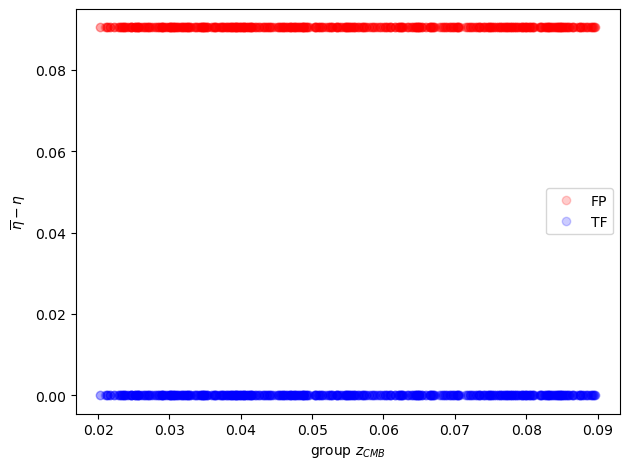

In [18]:
plt.figure(tight_layout=True)
plt.plot(match["zcmb_gr_x"], match["logdist_mean_x"] - match["LOGDIST_FP"], 'ro', alpha=0.2, label='FP')
plt.plot(match["zcmb_gr_x"], match["logdist_mean_y"] - match["LOGDIST_TF"], 'bo', alpha=0.2, label='TF')
plt.legend()
plt.xlabel('group $z_{CMB}$')
plt.ylabel('$\overline{\eta} - \eta$');
# plt.title('Fundamental Plane')

# plt.figure(tight_layout=True)
# plt.plot(match["zcmb_gr_x"], match["logdist_mean_y"] - match["LOGDIST_TF"], 'bo', alpha=0.2)
# plt.xlabel('zcmb_gr_x')
# plt.ylabel('logdist_mean_x - LOGDIST_TF')
# plt.title('Tully-Fisher');

We expect that the TF sample have a net 0 difference because the TFR is already 0pted, but we expect a non-zero offset for the FP because it is not yet 0pted.

In [23]:
"""lookup_zsel = (lookup["zcmb_gr"]>0.02) & (lookup["zcmb_gr"]<0.09)
sel = (
    (lookup["MU_FP"] != 0.0)
    & (lookup["MU_TF"] != 0.0)
    & (~lookup.duplicated(subset="group", keep="first"))
)
mean_FP_wtd,_,_ = weighted_avg_and_std(lookup["MU_FP"][sel&lookup_zsel], weights=(1.0 / lookup["MU_FP_ERR"][sel&lookup_zsel]**2))
print(lookup["group"][sel&lookup_zsel], lookup["MU_FP"][sel&lookup_zsel], data_FP_and_TF_groups["mu_mean_x"])"""

# Compute the weighted average distance modulus offset amongst all the groups
FP_TF_ZP = np.average(data_FP_and_TF_groups["mu_diff"], 
                      weights=1.0/data_FP_and_TF_groups["mu_diff_err"]**2)
FP_TF_ZP_err = np.sqrt(1.0/np.sum(1.0/data_FP_and_TF_groups["mu_diff_err"]**2))

# Compute the weighted average log distance ratio offset amongst all the groups
FP_TF_ZP_logdist = 5.0 * np.average(data_FP_and_TF_groups["logdist_diff"], 
                                    weights=1.0/data_FP_and_TF_groups["logdist_diff_err"]**2)
FP_TF_ZP_logdist_err = 5.0 * np.sqrt(1.0/np.sum(1.0/data_FP_and_TF_groups["logdist_diff_err"]**2))

# Compute the weighted average distance modulus across all the groups from the TF galaxies
FP_TF_ZP_alternate = np.average(data_FP_and_TF_groups["mu_mean_y"], 
                                weights=1.0/data_FP_and_TF_groups["mu_mean_err_y"]**2) - np.average(data_FP_and_TF_groups["mu_mean_x"], 
                                                                                                    weights=1.0/data_FP_and_TF_groups["mu_mean_err_x"]**2)
FP_TF_ZP_alternate_err = np.sqrt((1.0/np.sum(1.0/data_FP_and_TF_groups["mu_mean_err_y"]**2)) + (1.0/np.sum(1.0/data_FP_and_TF_groups["mu_mean_err_x"]**2)))

# Compute the weighted average log distance ratio across all the groups from the TF galaxies
FP_TF_ZP_alternate_logdist = 5.0 * (np.average(data_FP_and_TF_groups["logdist_mean_y"], 
                                               weights=1.0/data_FP_and_TF_groups["logdist_mean_err_y"]**2) - np.average(data_FP_and_TF_groups["logdist_mean_x"], 
                                                                                                                        weights=1.0/data_FP_and_TF_groups["logdist_mean_err_x"]**2))
FP_TF_ZP_alternate_logdist_err = 5.0 * np.sqrt((1.0/np.sum(1.0/data_FP_and_TF_groups["logdist_mean_err_y"]**2)) + (1.0/np.sum(1.0/data_FP_and_TF_groups["logdist_mean_err_x"]**2)))

# Compute the average log distance ratio of all the TF galaxies (from data)
FP_TF_ZP_all_logdist = 5.0 * (np.average(data_TF_full["LOGDIST"], 
                                         weights=1.0/data_TF_full["LOGDIST_ERR"]**2) - np.average(data_FP_full["LOGDIST"], 
                                                                                                  weights=1.0/data_FP_full["LOGDIST_ERR"]**2))
FP_TF_ZP_all_logdist_err = 5.0 * np.sqrt((1.0/np.sum(1.0/data_FP_full["LOGDIST_ERR"]**2)) + (1.0/np.sum(1.0/data_TF_full["LOGDIST_ERR"]**2)))

print('Number of groups with both FP and TF galaxies:', len(data_FP_and_TF_groups))
print('Average TF averaged distance moduli:', np.average(data_FP_and_TF_groups["mu_mean_y"], 
                                                         weights=1.0/data_FP_and_TF_groups["mu_mean_err_y"]**2))
print('Average FP average distance moduli:', np.average(data_FP_and_TF_groups["mu_mean_x"], 
                                                        weights=1.0/data_FP_and_TF_groups["mu_mean_err_x"]**2))
print('Average TF averaged log distance ratio:', np.average(data_FP_and_TF_groups["logdist_mean_y"], 
                                                            weights=1.0/data_FP_and_TF_groups["logdist_mean_err_y"]**2))
print('Average FP averaged log distance ratio:', np.average(data_FP_and_TF_groups["logdist_mean_x"], 
                                                            weights=1.0/data_FP_and_TF_groups["logdist_mean_err_x"]**2))
print('Average distance modulus offset:', FP_TF_ZP, '+/-', FP_TF_ZP_err)
print('Average log distance ratio offset:', FP_TF_ZP_logdist, '+/-', FP_TF_ZP_logdist_err)
print('Average group distance modulus with TF galaxies:', FP_TF_ZP_alternate, '+/-', FP_TF_ZP_alternate_err)
print('Average group log distance ratio with TF galaxies:', FP_TF_ZP_alternate_logdist, '+/-', FP_TF_ZP_alternate_logdist_err)
print('Average TF galaxy log distance ratio:', FP_TF_ZP_all_logdist, '+/-', FP_TF_ZP_all_logdist_err)
print('FP MU_ERR min:', np.amin(data_FP_full["MU_ERR"]))
print('FP MU_ERR max:', np.amax(data_FP_full["MU_ERR"]))
print('TF MU_ERR min:', np.amin(data_TF_full["MU_ERR"]))
print('TF MU_ERR max:', np.amax(data_TF_full["MU_ERR"])) 

Number of groups with both FP and TF galaxies: 834
Average TF averaged distance moduli: 36.441261647813974
Average FP average distance moduli: 35.96973203880954
Average TF averaged log distance ratio: -0.09768907364521859
Average FP averaged log distance ratio: -0.007292985600913337
Average distance modulus offset: 0.5640692238410793 +/- 0.026987585827803518
Average log distance ratio offset: -0.5651732826495741 +/- 0.026987585827803515
Average group distance modulus with TF galaxies: 0.47152960900443475 +/- 0.024868277168799708
Average group log distance ratio with TF galaxies: -0.4519804402215263 +/- 0.024868277168799708
Average TF galaxy log distance ratio: -0.4661095942156412 +/- 0.007901240624826712
FP MU_ERR min: 0.47415997754975403
FP MU_ERR max: 1.2386212000007788
TF MU_ERR min: 0.6644774157092934
TF MU_ERR max: 3.44658165116937


In [27]:
wFP = (1.0 / data_FP_and_TF_groups["logdist_mean_err_x"]**2)
wTF = (1.0 / data_FP_and_TF_groups["logdist_mean_err_y"]**2)
wdiff = (1.0 / data_FP_and_TF_groups["logdist_diff_err"]**2)


print("FP\n--------------")
print(np.average(data_FP_and_TF_groups["logdist_mean_x"], 
                 weights=wFP) - np.average(data_FP_full["LOGDIST"], 
                                           weights = 1.0/data_FP_full["LOGDIST_ERR"]**2), 
      np.average(data_FP_and_TF_groups["logdist_mean_x"], 
                 weights=wdiff) - np.average(data_FP_full["LOGDIST"], 
                                             weights = 1.0/data_FP_full["LOGDIST_ERR"]**2))
print(weighted_ks_2samp(data_FP_and_TF_groups["logdist_mean_x"], 
                        data_FP_full["LOGDIST"], 
                        1.0/data_FP_and_TF_groups["logdist_mean_err_x"]**2, 
                        1.0/data_FP_full["LOGDIST_ERR"]**2))
print(weighted_ks_2samp(data_FP_and_TF_groups["logdist_mean_x"], 
                        data_FP_full["LOGDIST"], 
                        1.0/data_FP_and_TF_groups["logdist_diff_err"]**2, 
                        1.0/data_FP_full["LOGDIST_ERR"]**2))


print("TF\n--------------")
print(np.average(data_FP_and_TF_groups["logdist_mean_y"], 
                 weights=wTF) - np.average(data_TF_full["LOGDIST"], 
                                           weights = 1.0/data_TF_full["LOGDIST_ERR"]**2), 
      np.average(data_FP_and_TF_groups["logdist_mean_y"], 
                 weights=wdiff) - np.average(data_TF_full["LOGDIST"], 
                                             weights = 1.0/data_TF_full["LOGDIST_ERR"]**2))
print(weighted_ks_2samp(data_FP_and_TF_groups["logdist_mean_y"], 
                        data_TF_full["LOGDIST"], 
                        1.0/data_FP_and_TF_groups["logdist_mean_err_y"]**2, 
                        1.0/data_TF_full["LOGDIST_ERR"]**2))
print(weighted_ks_2samp(data_FP_and_TF_groups["logdist_mean_y"], 
                        data_TF_full["LOGDIST"], 
                        1.0/data_FP_and_TF_groups["logdist_diff_err"]**2, 
                        1.0/data_TF_full["LOGDIST_ERR"]**2))

FP
--------------
-0.0010247499676118285 0.0221192941464509
WeightedKstestResult(statistic=0.2017928129093598, pvalue=0.000999000999000999)
WeightedKstestResult(statistic=0.18447652721845276, pvalue=0.000999000999000999)
TF
--------------
0.001801080831211152 0.002306556459664294
WeightedKstestResult(statistic=0.04341979660958306, pvalue=0.13586413586413587)
WeightedKstestResult(statistic=0.044734180512651545, pvalue=0.10789210789210789)


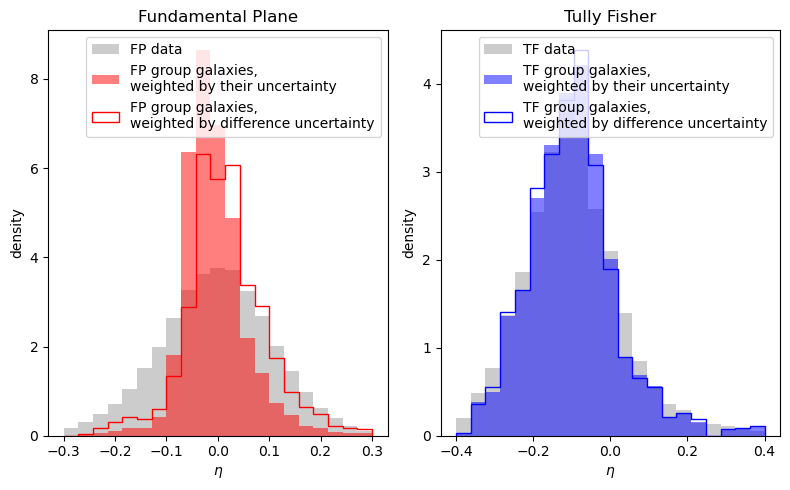

In [29]:
plt.figure(figsize=(8,5), tight_layout=True)

plt.subplot(121)
plt.hist(data_FP_full["LOGDIST"], 
         weights = 1.0/data_FP_full["LOGDIST_ERR"]**2, 
         bins=np.linspace(-0.3, 0.3, 22), 
         color='k', 
         alpha=0.2, 
         density=True, 
         label='FP data')
plt.hist(data_FP_and_TF_groups["logdist_mean_x"], 
         weights=wFP, 
         bins=np.linspace(-0.3, 0.3, 22), 
         color='r', 
         alpha=0.5, 
         density=True, 
         label='FP group galaxies,\nweighted by their uncertainty') 
plt.hist(data_FP_and_TF_groups["logdist_mean_x"], 
         weights=wdiff, 
         bins=np.linspace(-0.3, 0.3, 22), 
         color='r', 
         histtype='step', 
         density=True, 
         label='FP group galaxies,\nweighted by difference uncertainty')

plt.legend()

plt.title('Fundamental Plane')
plt.xlabel('$\eta$')
plt.ylabel('density')


plt.subplot(122)
plt.hist(data_TF_full["LOGDIST"], 
         weights = 1.0/data_TF_full["LOGDIST_ERR"]**2, 
         bins=np.linspace(-0.4, 0.4, 22), 
         color='k', 
         alpha=0.2, 
         density=True, 
         label='TF data')
plt.hist(data_FP_and_TF_groups["logdist_mean_y"], 
         weights=wTF, 
         bins=np.linspace(-0.4, 0.4, 22), 
         color='b', 
         alpha=0.5, 
         density=True, 
         label='TF group galaxies,\nweighted by their uncertainty') 
plt.hist(data_FP_and_TF_groups["logdist_mean_y"], 
         weights=wdiff, 
         bins=np.linspace(-0.4, 0.4, 22), 
         color='b', 
         histtype='step', 
         density=True, 
         label='TF group galaxies,\nweighted by difference uncertainty') 

plt.legend()

plt.title('Tully Fisher')
plt.xlabel('$\eta$')
plt.ylabel('density');

In [32]:
"""
nzbin=8
wFP = (1.0 / data_FP_and_TF_groups["mu_mean_err_x"]**2)
wTF = (1.0 / data_FP_and_TF_groups["mu_mean_err_y"]**2)
wdiff = (1.0 / data_FP_and_TF_groups["mu_diff_err"]**2)
bins = np.linspace(0.02, 0.09, nzbin)
for k in range(len(bins)-1):
    print("FP\n--------------")
    index = np.where(np.logical_and(data_FP_full["zcmb"] > bins[k], data_FP_full["zcmb"] <= bins[k+1]))[0]
    plt.hist(data_FP_full["MU"].iloc[index], weights = 1.0/data_FP_full["MU_ERR"].iloc[index]**2, bins=np.linspace(32, 39, 22), color='k', alpha=0.2, density=True)
    index2 = np.where(np.logical_and(data_FP_and_TF_groups["zcmb_gr_x"] > bins[k], data_FP_and_TF_groups["zcmb_gr_x"] <= bins[k+1]))[0]
    plt.hist(data_FP_and_TF_groups["mu_mean_x"][index2], weights=wFP[index2], bins=np.linspace(32, 39, 22), color='r', alpha=0.5, density=True) 
    plt.hist(data_FP_and_TF_groups["mu_mean_x"][index2], weights=wdiff[index2], bins=np.linspace(32, 39, 22), color='r', histtype='step', density=True) 
    plt.show()
    print(bins[k], bins[k+1], np.average(data_FP_and_TF_groups["mu_mean_x"][index2], weights=wFP[index2])-np.average(data_FP_full["MU"].iloc[index], weights = 1.0/data_FP_full["MU_ERR"].iloc[index]**2), np.average(data_FP_and_TF_groups["mu_mean_x"][index2], weights=wdiff[index2])-np.average(data_FP_full["MU"].iloc[index], weights = 1.0/data_FP_full["MU_ERR"].iloc[index]**2))
    print(weighted_ks_2samp(data_FP_and_TF_groups["mu_mean_x"][index2], data_FP_full["MU"].iloc[index], 1.0/data_FP_and_TF_groups["mu_mean_err_x"][index2]**2, 1.0/data_FP_full["MU_ERR"].iloc[index]**2))
    print(weighted_ks_2samp(data_FP_and_TF_groups["mu_mean_x"][index2], data_FP_full["MU"].iloc[index], 1.0/data_FP_and_TF_groups["mu_diff_err"][index2]**2, 1.0/data_FP_full["MU_ERR"].iloc[index]**2))

    print("TF\n--------------")
    index = np.where(np.logical_and(data_TF_full["zcmb"] > bins[k], data_TF_full["zcmb"] <= bins[k+1]))[0]
    plt.hist(data_TF_full["MU"].iloc[index], weights = 1.0/data_TF_full["MU_ERR"].iloc[index]**2, bins=np.linspace(32, 39, 22), color='k', alpha=0.2, density=True)
    index2 = np.where(np.logical_and(data_FP_and_TF_groups["zcmb_gr_x"] > bins[k], data_FP_and_TF_groups["zcmb_gr_x"] <= bins[k+1]))[0]
    plt.hist(data_FP_and_TF_groups["mu_mean_y"][index2], weights=wTF[index2], bins=np.linspace(32, 39, 22), color='b', alpha=0.5, density=True) 
    plt.hist(data_FP_and_TF_groups["mu_mean_y"][index2], weights=wdiff[index2], bins=np.linspace(32, 39, 22), color='b', histtype='step', density=True) 
    plt.show()
    print(bins[k], bins[k+1], np.average(data_FP_and_TF_groups["mu_mean_y"][index2], weights=wTF[index2])-np.average(data_TF_full["MU"].iloc[index], weights = 1.0/data_TF_full["MU_ERR"].iloc[index]**2), np.average(data_FP_and_TF_groups["mu_mean_y"][index2], weights=wdiff[index2])-np.average(data_TF_full["MU"].iloc[index], weights = 1.0/data_TF_full["MU_ERR"].iloc[index]**2))
    print(weighted_ks_2samp(data_FP_and_TF_groups["mu_mean_y"][index2], data_TF_full["MU"].iloc[index], 1.0/data_FP_and_TF_groups["mu_mean_err_y"][index2]**2, 1.0/data_TF_full["MU_ERR"].iloc[index]**2))
    print(weighted_ks_2samp(data_FP_and_TF_groups["mu_mean_y"][index2], data_TF_full["MU"].iloc[index], 1.0/data_FP_and_TF_groups["mu_diff_err"][index2]**2, 1.0/data_TF_full["MU_ERR"].iloc[index]**2))
    """;
    
#data_FP_and_TF_groups = data_FP_and_TF_groups.drop(data_FP_and_TF_groups[(data_FP_and_TF_groups["zcmb_gr_x"] < 0.02) | (data_FP_and_TF_groups["zcmb_gr_x"] > 0.09)].index)
#FP_TF_ZP = np.average(data_FP_and_TF_groups["mu_diff"], weights=1.0/data_FP_and_TF_groups["mu_diff_err"]**2)
#FP_TF_ZP_err = np.sqrt(1.0/np.sum(1.0/data_FP_and_TF_groups["mu_diff_err"]**2))
#FP_TF_ZP_logdist = 5.0 * np.average(data_FP_and_TF_groups["logdist_diff"], weights=1.0/data_FP_and_TF_groups["logdist_diff_err"]**2)
#FP_TF_ZP_logdist_err = 5.0 * np.sqrt(1.0/np.sum(1.0/data_FP_and_TF_groups["logdist_diff_err"]**2))
#print(FP_TF_ZP, FP_TF_ZP_err, FP_TF_ZP_logdist, FP_TF_ZP_logdist_err)
#print(np.average(data_FP_and_TF_groups["mu_mean_y"], weights=1.0/data_FP_and_TF_groups["mu_mean_err_y"]**2) - np.average(data_FP_and_TF_groups["mu_mean_x"], weights=1.0/data_FP_and_TF_groups["mu_mean_err_x"]**2))
#print(5.0*(np.average(data_FP_and_TF_groups["logdist_mean_y"], weights=1.0/data_FP_and_TF_groups["logdist_mean_err_y"]**2) - np.average(data_FP_and_TF_groups["logdist_mean_x"], weights=1.0/data_FP_and_TF_groups["logdist_mean_err_x"]**2)))

# Redo the calculation on the cleaned clustering data to check for consistency
#data_TF_clustering_groups = data_TF.merge(lookup, left_on="SGA_ID", right_on="ID")
#data_TF_clustering_groups = data_TF_clustering_groups.groupby(by='group').apply(weighted_agg)
#data_FP_clustering_groups = data_FP.merge(lookup, left_on="TARGETID", right_on="ID")
#data_FP_clustering_groups = data_FP_clustering_groups.groupby(by='group').apply(weighted_agg)
#data_FP_and_TF_clustering_groups = data_FP_clustering_groups.merge(data_TF_clustering_groups, on="group")
#data_FP_and_TF_clustering_groups["mu_diff"] = data_FP_and_TF_clustering_groups["mu_mean_y"] - data_FP_and_TF_clustering_groups["mu_mean_x"]
#data_FP_and_TF_clustering_groups["mu_diff_err"] = np.sqrt(data_FP_and_TF_clustering_groups["mu_mean_err_y"]**2 + data_FP_and_TF_clustering_groups["mu_mean_err_x"]**2)
#data_FP_and_TF_clustering_groups["logdist_diff"] = data_FP_and_TF_clustering_groups["logdist_mean_y"] - data_FP_and_TF_clustering_groups["logdist_mean_x"]
#data_FP_and_TF_clustering_groups["logdist_diff_err"] = np.sqrt(data_FP_and_TF_clustering_groups["logdist_mean_err_y"]**2 + data_FP_and_TF_clustering_groups["logdist_mean_err_x"]**2)
#FP_TF_clustering_ZP = np.average(data_FP_and_TF_clustering_groups["mu_diff"], weights=1.0/data_FP_and_TF_clustering_groups["mu_diff_err"]**2)
#FP_TF_clustering_ZP_err = np.sqrt(1.0/np.sum(1.0/data_FP_and_TF_clustering_groups["mu_diff_err"]**2))
#FP_TF_clustering_ZP_logdist = 5.0*np.average(data_FP_and_TF_clustering_groups["logdist_diff"], weights=1.0/data_FP_and_TF_clustering_groups["logdist_diff_err"]**2)
#FP_TF_clustering_ZP_logdist_err = 5.0*np.sqrt(1.0/np.sum(1.0/data_FP_and_TF_clustering_groups["logdist_diff_err"]**2))
#print(FP_TF_clustering_ZP, FP_TF_clustering_ZP_err, FP_TF_clustering_ZP_logdist, FP_TF_clustering_ZP_logdist_err)

# Hubble diagrams

## Individual galaxies

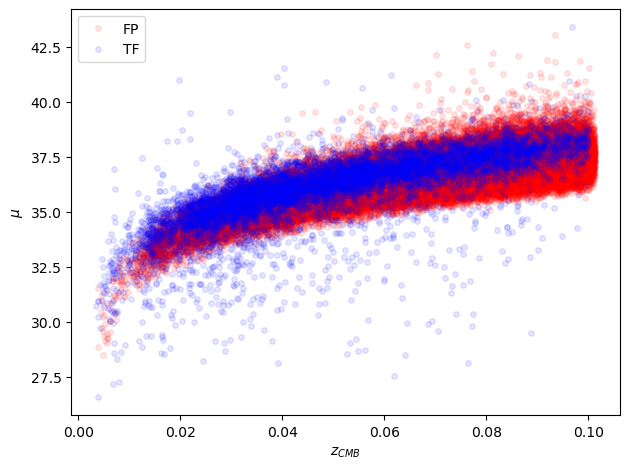

In [33]:
plt.figure(tight_layout=True)

plt.plot(data_FP_full["zcmb"], data_FP_full["MU"], marker='o', color='r', ms=4, ls='None', alpha=0.1, label='FP')
plt.plot(data_TF_full["zcmb"], data_TF_full["MU"], marker='o', color='b', ms=4, ls='None', alpha=0.1, label='TF')

plt.legend()

plt.xlabel('$z_{CMB}$')
plt.ylabel('$\mu$');

## Groups

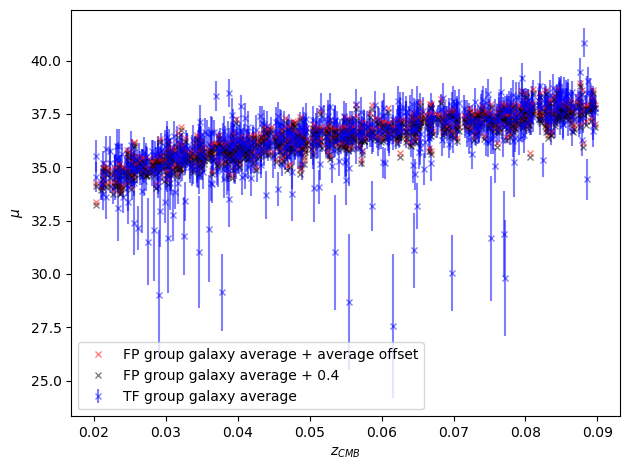

In [34]:
plt.figure(tight_layout=True)

plt.errorbar(data_FP_and_TF_groups["zcmb_gr_x"], data_FP_and_TF_groups["mu_mean_y"], 
             yerr = data_FP_and_TF_groups["mu_mean_err_y"], 
             marker='x', color='b', ms=4, ls='None', alpha=0.5, 
             label='TF group galaxy average')

plt.plot(data_FP_and_TF_groups["zcmb_gr_x"], 
         data_FP_and_TF_groups["mu_mean_x"]+FP_TF_ZP, 
         marker='x', color='r', ms=4, ls='None', alpha=0.5, 
         label='FP group galaxy average + average offset')

plt.plot(data_FP_and_TF_groups["zcmb_gr_x"], 
         data_FP_and_TF_groups["mu_mean_x"]+0.4, 
         marker='x', color='k', ms=4, ls='None', alpha=0.5, 
         label='FP group galaxy average + 0.4')

plt.legend()

plt.xlabel('$z_{CMB}$')
plt.ylabel('$\mu$');

## Groups and galaxies

-0.00900540415605576
0.005123749838059142


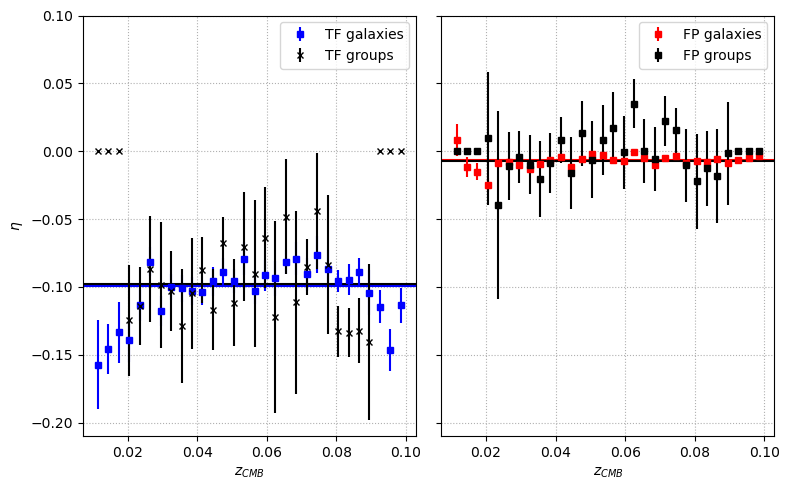

In [44]:
# Binned Hubble diagram for groups and galaxies
nzbin=31
bins = np.linspace(zmin, zmax, nzbin)

# TF arrays
data_TF_mean, data_TF_mean_err, data_TF_std = np.zeros(nzbin-1), np.zeros(nzbin-1), np.zeros(nzbin-1)
data_TF_group_mean, data_TF_group_mean_err, data_TF_group_std = np.zeros(nzbin-1), np.zeros(nzbin-1), np.zeros(nzbin-1)

# FP arrays
data_FP_mean, data_FP_mean_err, data_FP_std = np.zeros(nzbin-1), np.zeros(nzbin-1), np.zeros(nzbin-1)
data_FP_group_mean, data_FP_group_mean_err, data_FP_group_std = np.zeros(nzbin-1), np.zeros(nzbin-1), np.zeros(nzbin-1)


for k in range(len(bins)-1):

    #---------------------------------------------------------------------------
    # TF galaxies
    #---------------------------------------------------------------------------
    index = np.where(np.logical_and(data_TF_full["zcmb"] > bins[k], 
                                    data_TF_full["zcmb"] <= bins[k+1]))[0]

    if len(index) > 0:
        data_TF_mean[k], data_TF_mean_err[k], data_TF_std[k] = weighted_avg_and_std(data_TF_full["LOGDIST"].to_numpy()[index], 
                                                                                    1.0/data_TF_full["LOGDIST_ERR"].to_numpy()[index]**2)
    #---------------------------------------------------------------------------
    # FP galaxies
    #---------------------------------------------------------------------------
    index = np.where(np.logical_and(data_FP_full["zcmb"] > bins[k], 
                                    data_FP_full["zcmb"] <= bins[k+1]))[0]
    
    if len(index) > 0:
        data_FP_mean[k], data_FP_mean_err[k], data_FP_std[k] = weighted_avg_and_std(data_FP_full["LOGDIST"].to_numpy()[index], 
                                                                                    1.0/data_FP_full["LOGDIST_ERR"].to_numpy()[index]**2)
    #---------------------------------------------------------------------------
    # Groups
    #---------------------------------------------------------------------------
    index = np.where(np.logical_and(data_FP_and_TF_groups["zcmb_gr_x"] > bins[k], 
                                    data_FP_and_TF_groups["zcmb_gr_x"] <= bins[k+1]))[0]
    if len(index) > 0:
        data_TF_group_mean[k], data_TF_group_mean_err[k], data_TF_group_std[k] = weighted_avg_and_std(data_FP_and_TF_groups["logdist_mean_y"].to_numpy()[index], 
                                                                                                      1.0/data_FP_and_TF_groups["logdist_mean_err_y"].to_numpy()[index]**2)
    
        data_FP_group_mean[k], data_FP_group_mean_err[k], data_FP_group_std[k] = weighted_avg_and_std(data_FP_and_TF_groups["logdist_mean_x"].to_numpy()[index], 
                                                                                                      1.0/data_FP_and_TF_groups["logdist_mean_err_x"].to_numpy()[index]**2)

    
print(5.0*(weighted_avg_and_std(data_TF_full["LOGDIST"].to_numpy(), 
                                1.0/data_TF_full["LOGDIST_ERR"].to_numpy()**2)[0] - weighted_avg_and_std(data_FP_and_TF_groups["logdist_mean_y"].to_numpy(), 
                                                                                                         1.0/data_FP_and_TF_groups["logdist_mean_err_y"].to_numpy()**2)[0]))
print(5.0*(weighted_avg_and_std(data_FP_full["LOGDIST"].to_numpy(), 
                                1.0/data_FP_full["LOGDIST_ERR"].to_numpy()**2)[0] - weighted_avg_and_std(data_FP_and_TF_groups["logdist_mean_x"].to_numpy(), 
                                                                                                         1.0/data_FP_and_TF_groups["logdist_mean_err_x"].to_numpy()**2)[0]))



# Plot the individual and group Hubble diagrams
plt.figure(figsize=(8,5), tight_layout=True)

ax1 = plt.subplot(121)
plt.errorbar((bins[1:]+bins[:-1])/2.0, data_TF_mean, 
             yerr=data_TF_mean_err, 
             ls='None', mfc='b', mec='b', marker='s', color='b', ms=4, zorder=3, 
             label='TF galaxies')

plt.errorbar((bins[1:]+bins[:-1])/2.0, data_TF_group_mean, 
             yerr=data_TF_group_mean_err, 
             ls='None', mfc='k', mec='k', marker='x', color='k', ms=4, zorder=3, 
             label='TF groups')

plt.axhline(y=weighted_avg_and_std(data_TF_full["LOGDIST"].to_numpy(), 
                                   1.0/data_TF_full["LOGDIST_ERR"].to_numpy()**2)[0], 
            color='b', ls='-')
plt.axhline(y=weighted_avg_and_std(data_FP_and_TF_groups["logdist_mean_y"].to_numpy(), 
                                   1.0/data_FP_and_TF_groups["logdist_mean_err_y"].to_numpy()**2)[0], 
            color='k', ls='-')

plt.grid(ls=':')

plt.legend()

plt.ylim(-0.21, 0.1)

plt.xlabel('$z_{CMB}$')
plt.ylabel('$\eta$')


plt.subplot(122, sharex=ax1, sharey=ax1)
plt.errorbar((bins[1:]+bins[:-1])/2.0, data_FP_mean, 
             yerr=data_FP_mean_err, 
             ls='None', mfc='r', mec='r', marker='s', color='r', ms=4, zorder=3, 
             label='FP galaxies')
plt.errorbar((bins[1:]+bins[:-1])/2.0, data_FP_group_mean, 
             yerr=data_FP_group_mean_err, 
             ls='None', mfc='k', mec='k', marker='s', color='k', ms=4, zorder=3, 
             label='FP groups')

plt.axhline(y=weighted_avg_and_std(data_FP_full["LOGDIST"].to_numpy(), 
                                   1.0/data_FP_full["LOGDIST_ERR"].to_numpy()**2)[0], 
            color='r', ls='-')
plt.axhline(y=weighted_avg_and_std(data_FP_and_TF_groups["logdist_mean_x"].to_numpy(), 
                                   1.0/data_FP_and_TF_groups["logdist_mean_err_x"].to_numpy()**2)[0], 
            color='k', ls='-')

plt.grid(ls=':')

plt.legend()

plt.tick_params('y', labelleft=False)
plt.xlabel('$z_{CMB}$');

[0.         0.         0.         0.74856506 0.71253219 0.48462274
 0.58405695 0.47554297 0.66599793 0.65941967 0.54736652 0.56543666
 0.47033116 0.67673514 0.45017677 0.63417977 0.31067103 0.84938547
 0.23313858 0.5263156  0.58913304 0.2978782  0.58766978 0.61723528
 0.72759589 0.65652216 0.73403022 0.         0.         0.        ]


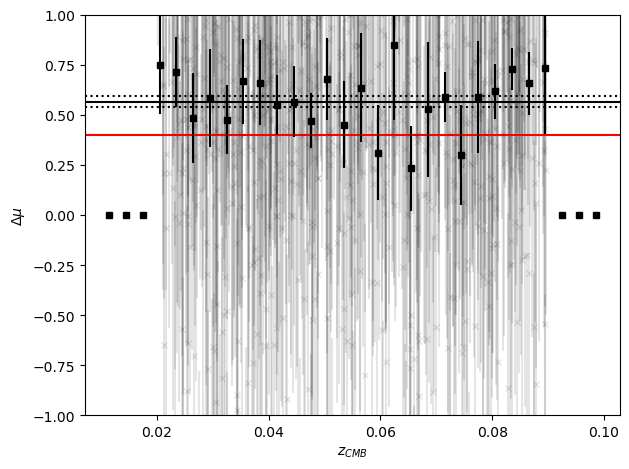

In [47]:
# Plot the individual and group Hubble diagrams
nzbin=31
bins = np.linspace(zmin, zmax, nzbin)
data_mean, data_mean_err, data_std = np.zeros(nzbin-1), np.zeros(nzbin-1), np.zeros(nzbin-1)

for k in range(len(bins)-1):
    index = np.where(np.logical_and(data_FP_and_TF_groups["zcmb_gr_x"] > bins[k], 
                                    data_FP_and_TF_groups["zcmb_gr_x"] <= bins[k+1]))[0]
    if len(index) > 0:
        data_mean[k], data_mean_err[k], data_std[k] = weighted_avg_and_std(data_FP_and_TF_groups["mu_diff"].to_numpy()[index], 
                                                                           1.0/data_FP_and_TF_groups["mu_diff_err"].to_numpy()[index]**2)
print(data_mean)

# Plot the individual and group Hubble diagrams
plt.figure(tight_layout=True)

plt.errorbar(data_FP_and_TF_groups["zcmb_gr_x"], data_FP_and_TF_groups["mu_diff"], 
             yerr = data_FP_and_TF_groups["mu_diff_err"], 
             marker='x', color='k', ms=4, ls='None', alpha=0.1)
plt.errorbar((bins[1:]+bins[:-1])/2.0, data_mean, 
             yerr=data_mean_err, 
             ls='None', mfc='k', mec='k', marker='s', color='k', ms=4, zorder=3)
#plt.errorbar(data_FP_and_TF_clustering_groups["zcmb"], data_FP_and_TF_clustering_groups["mu_diff"], yerr = data_FP_and_TF_clustering_groups["mu_diff_err"], marker='x', color='cyan', ms=4, ls='None', alpha=0.1)

plt.axhline(y=FP_TF_ZP, color='k', ls='-')
plt.axhline(y=0.4, color='r', ls='-')
plt.axhline(y=FP_TF_ZP - FP_TF_ZP_err, color='k', ls=':')
plt.axhline(y=FP_TF_ZP + FP_TF_ZP_err, color='k', ls=':')

plt.ylim(-1.0, 1.0)

plt.xlabel('$z_{CMB}$')
plt.ylabel('$\Delta \mu$');

# Compute the zero-point for the calibrated FP+TF sample

Based on SNe cross-matches.

-----------------------------------------------------
ZP = [0.5640692238410793, 0.026987585827803518]


/tmp/ipykernel_158244/7684166.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_comb_groups = data_comb_groups.groupby(by='group').apply(weighted_agg2)
/tmp/ipykernel_158244/7684166.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  SNe_groups = SNe_cut.groupby(by="group").apply(weighted_agg)


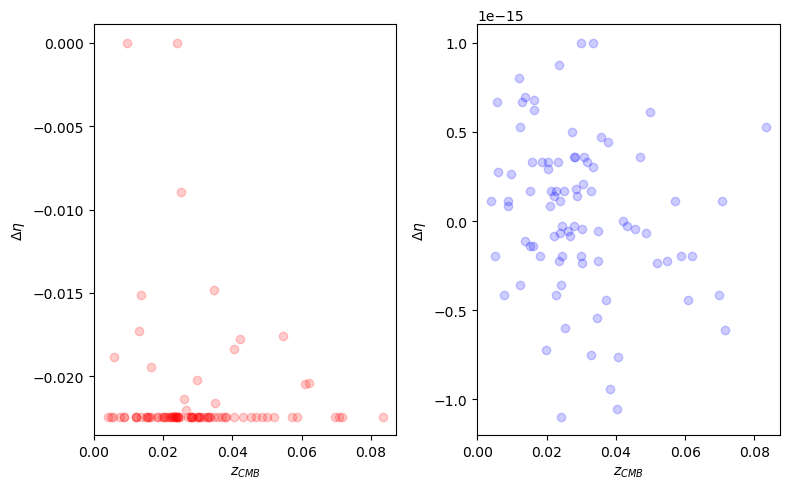

0.015165728442500331 -0.0125079418345488
35.325858053910714 35.28772640042818
-0.14098658782125537 -0.1180317225381659
0.07786694545023706 0.035581421085483664
-0.10141071170884254 0.035581421085483664
0.03813165348253733 0.02555455851704275
-0.1147743264154473 0.02555455851704275


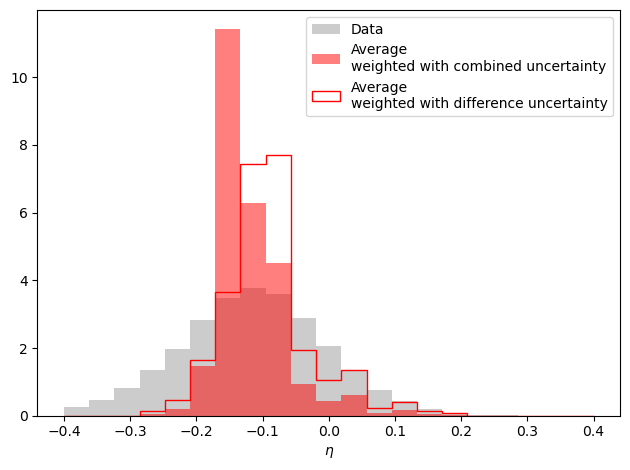

0.0 0.027673670277049117
-----------------------------------------------------
ZP = [0.5651732826495741, 0.026987585827803515]


/tmp/ipykernel_158244/7684166.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_comb_groups = data_comb_groups.groupby(by='group').apply(weighted_agg2)
/tmp/ipykernel_158244/7684166.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  SNe_groups = SNe_cut.groupby(by="group").apply(weighted_agg)


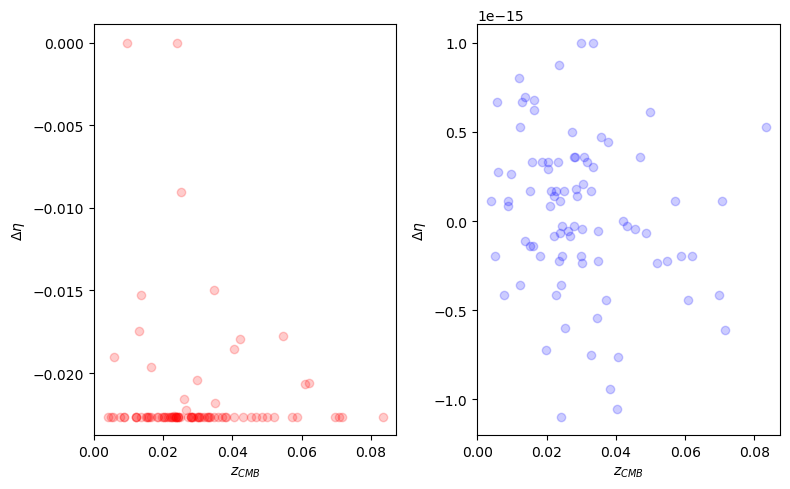

0.01517114879797278 -0.012507979349184573
35.325858053910714 35.28877132950286
-0.14098658782125537 -0.11824070835310159
0.07682201637555947 0.035581421085483664
-0.1003657826341641 0.035581421085483664
0.037086724407856764 0.02555455851704275
-0.11372939734076888 0.02555455851704275


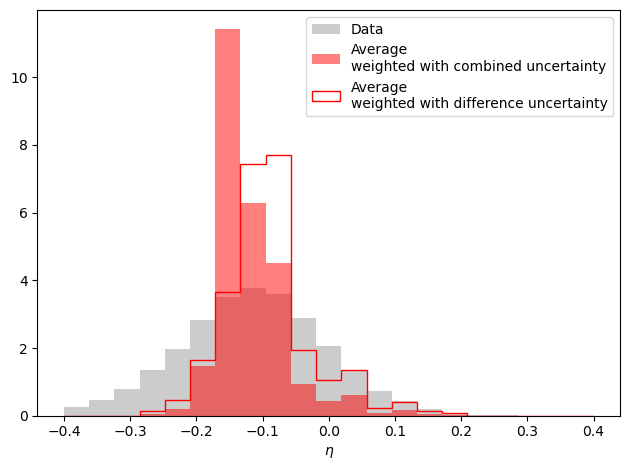

2.7755575615628914e-17 0.027679128147157367
-----------------------------------------------------
ZP = [0.47152960900443475, 0.024868277168799708]


/tmp/ipykernel_158244/7684166.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_comb_groups = data_comb_groups.groupby(by='group').apply(weighted_agg2)
/tmp/ipykernel_158244/7684166.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  SNe_groups = SNe_cut.groupby(by="group").apply(weighted_agg)


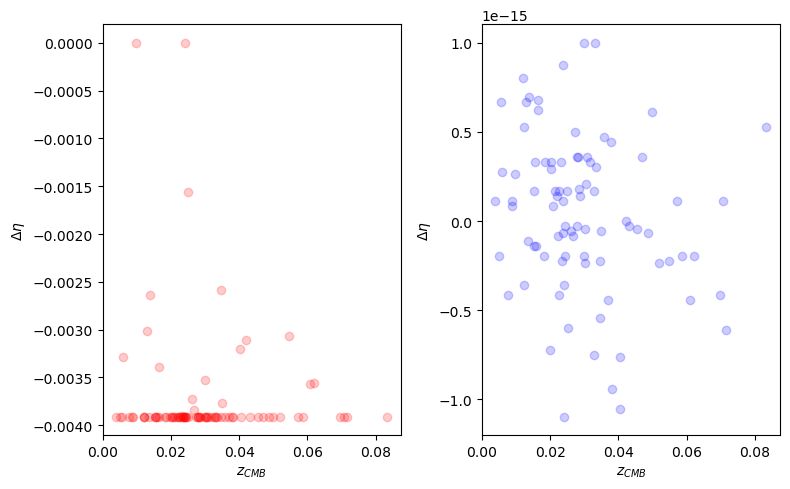

0.014713469401761853 -0.012505777682252125
35.325858053910714 35.20013707529062
-0.14098658782125537 -0.1005152039615809
0.16545045577961517 0.035576919785720564
-0.18898962795683746 0.035576919785720564
0.12572097862009457 0.025550876204157278
-0.20235691929837235 0.02555087620415728


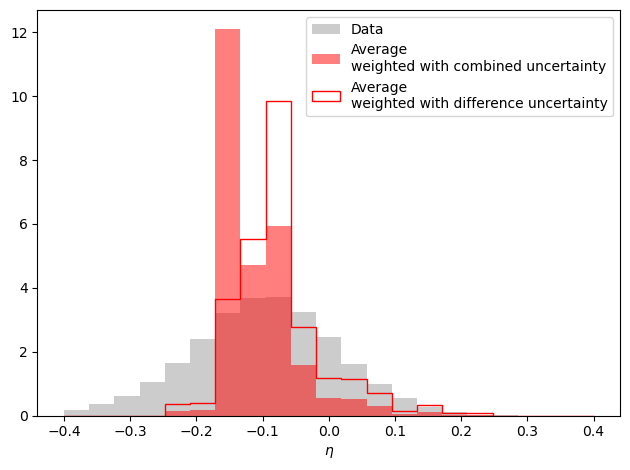

0.0 0.027219247084013992
-----------------------------------------------------
ZP = [0.4519804402215263, 0.024868277168799708]


/tmp/ipykernel_158244/7684166.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_comb_groups = data_comb_groups.groupby(by='group').apply(weighted_agg2)
/tmp/ipykernel_158244/7684166.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  SNe_groups = SNe_cut.groupby(by="group").apply(weighted_agg)


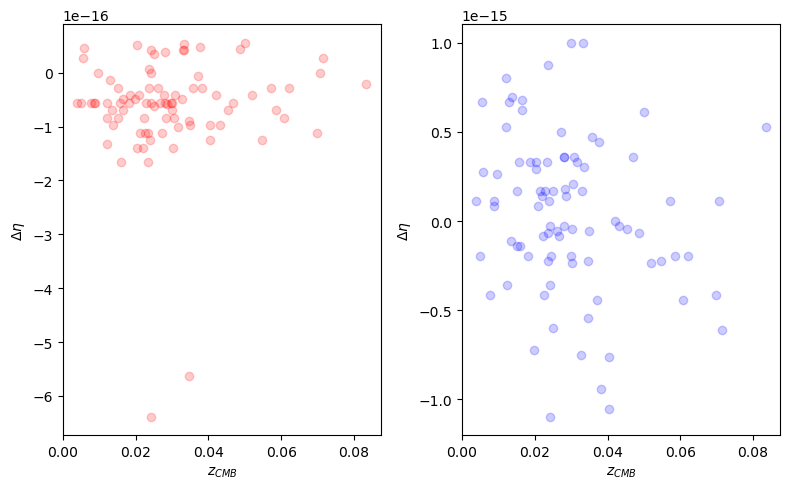

0.014617517141332165 -0.012505109839616418
35.325858053910714 35.18163454709192
-0.14098658782125537 -0.09681469832184086
0.18395298397831097 0.035576919785720564
-0.20749215615553745 0.035576919785720564
0.14422350681879692 0.025550876204157278
-0.2208594474970725 0.02555087620415728


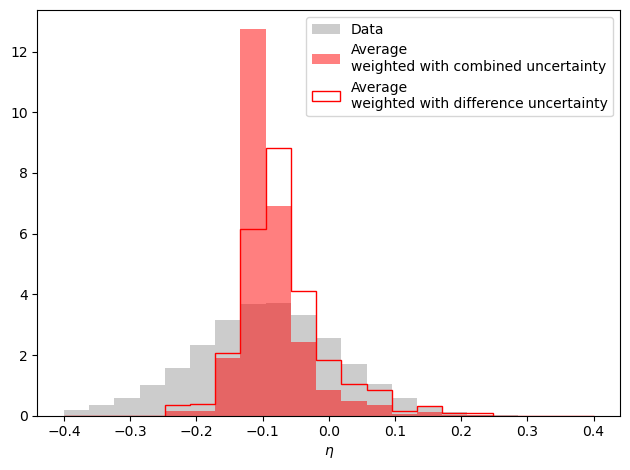

2.7755575615628914e-17 0.027122626980948597


In [49]:
# First produce a combined catalogue of the TF and FP data post-ZP calibration
def weighted_agg2(x):
    names = {'size': len(x),
             'zcmb_gr': np.mean(x["zcmb_gr"]),
             #'mu_FP_mean': np.average(x.loc[x['FP_FLAG']==1, 'MU'], weights=1.0/(x.loc[x['FP_FLAG']==1, 'MU_ERR']**2)) if len(x.loc[x['FP_FLAG']==1]) > 0 else np.nan,
             #'mu_FP_mean_err': np.sqrt(1.0/np.sum(1.0/x.loc[x['FP_FLAG']==1, 'MU_ERR']**2)) if len(x.loc[x['FP_FLAG']==1]) > 0 else np.nan,
             #'mu_TF_mean': np.average(x.loc[x['FP_FLAG']==0, 'MU'], weights=1.0/(x.loc[x['FP_FLAG']==0, 'MU_ERR']**2)) if len(x.loc[x['FP_FLAG']==0]) > 0 else np.nan,
             #'mu_TF_mean_err': np.sqrt(1.0/np.sum(1.0/x.loc[x['FP_FLAG']==0, 'MU_ERR']**2)) if len(x.loc[x['FP_FLAG']==0]) > 0 else np.nan,
             'mu_mean': np.average(x['MU'], weights=1.0/(x['MU_ERR']**2)),
             'mu_mean_err': np.sqrt(1.0/np.sum(1.0/x['MU_ERR']**2)),
             'logdist_mean': np.average(x['LOGDIST'], weights=1.0/(x['LOGDIST_ERR']**2)),
             'logdist_mean_err': np.sqrt(1.0/np.sum(1.0/x['LOGDIST_ERR']**2))}
    return pd.Series(names)

ZPs = [[FP_TF_ZP, FP_TF_ZP_err],
       [-FP_TF_ZP_logdist, FP_TF_ZP_logdist_err],
       [FP_TF_ZP_alternate, FP_TF_ZP_alternate_err],
       [-FP_TF_ZP_alternate_logdist, FP_TF_ZP_alternate_logdist_err]]
#ZPs = [[-FP_TF_ZP_alternate_logdist, FP_TF_ZP_alternate_logdist_err]]

PV_SNe_ZP, PV_SNe_ZP_err = np.zeros(len(ZPs)), np.zeros(len(ZPs))
PV_SNe_ZP_logdist, PV_SNe_ZP_logdist_err = np.zeros(len(ZPs)), np.zeros(len(ZPs))
PV_SNe_ZP_alternate, PV_SNe_ZP_alternate_err = np.zeros(len(ZPs)), np.zeros(len(ZPs))
PV_SNe_ZP_alternate_logdist, PV_SNe_ZP_alternate_logdist_err = np.zeros(len(ZPs)), np.zeros(len(ZPs))

for i, ZP in enumerate(ZPs):

    print('-----------------------------------------------------')
    print('ZP =', ZP)

    # Define FP_FLAG column, so that we can identify the two samples in the combined catalog
    data_TF_full["FP_FLAG"] = np.zeros(len(data_TF_full))
    data_FP_full["FP_FLAG"] = np.ones(len(data_FP_full))

    # Combine the two samples
    data_comb_full = pd.concat([data_TF_full, data_FP_full], ignore_index=True) 

    # Adjust FP distance moduli and log distance ratio zero-points to match TF sample
    data_comb_full.loc[data_comb_full['FP_FLAG']==1, 'MU'] = data_comb_full.loc[data_comb_full['FP_FLAG']==1, 'MU'] + ZP[0]
    data_comb_full.loc[data_comb_full['FP_FLAG']==1, 'MU_ERR'] = np.sqrt(data_comb_full.loc[data_comb_full['FP_FLAG']==1, 'MU_ERR']**2 + ZP[1]**2)
    data_comb_full.loc[data_comb_full['FP_FLAG']==1, 'LOGDIST'] = data_comb_full.loc[data_comb_full['FP_FLAG']==1, 'LOGDIST'] - ZP[0]/5.0
    data_comb_full.loc[data_comb_full['FP_FLAG']==1, 'LOGDIST_ERR'] = np.sqrt(data_comb_full.loc[data_comb_full['FP_FLAG']==1, 'LOGDIST_ERR']**2 + (ZP[1]/5.0)**2)

    # Adjust group distance moduli, log distance ratios as well
    data_TF_groups = data_TF_full.merge(lookup, left_on="SGA_ID", right_on="ID")
    data_FP_groups = data_FP_full.merge(lookup, left_on="targetid", right_on="ID")
    data_FP_groups["MU"] += ZP[0]
    data_FP_groups["MU_ERR"] = np.sqrt(data_FP_groups["MU_ERR"]**2 + ZP[1]**2)
    data_FP_groups["LOGDIST"] -= ZP[0]/5.0
    data_FP_groups["LOGDIST_ERR"] = np.sqrt(data_FP_groups["LOGDIST_ERR"]**2 + (ZP[1]/5.0)**2)

    # Combine TF, FP group catalogs
    data_comb_groups = pd.concat([data_TF_groups, data_FP_groups], ignore_index=True) 

    # Compute statistics of combined group catalog
    data_comb_groups = data_comb_groups.groupby(by='group').apply(weighted_agg2)
        
    # Now group the SNe distance moduli and cross-match to the data_comb_groups
    SNe_groups = SNe_cut.groupby(by="group").apply(weighted_agg)
    data_comb_and_SNe_groups = data_comb_groups.merge(SNe_groups, on="group")

    match = data_comb_and_SNe_groups.merge(lookup_desi, on="group")

    #---------------------------------------------------------------------------
    # Plot redshift v. log distance ratio differences
    #---------------------------------------------------------------------------
    plt.figure(figsize=(8,5), tight_layout=True)

    ax1 = plt.subplot(121)
    plt.errorbar(match["zcmb_gr_x"], 
                 match["logdist_mean_x"] - match["LOGDIST_DESI"], 
                 marker='o', color='r', ls="None", alpha=0.2, 
                 label='FP')
    plt.xlabel('$z_{CMB}$')
    plt.ylabel('$\Delta \eta$')

    plt.subplot(122, sharex=ax1)
    plt.errorbar(match["zcmb_gr_x"], 
                 match["logdist_mean_y"] - match["LOGDIST_SN"], 
                 marker='o', color='b', ls="None", alpha=0.2, 
                 label='TF')
    plt.xlabel('$z_{CMB}$')
    plt.ylabel('$\Delta \eta$')
    plt.show()
    #---------------------------------------------------------------------------

    # Just combine TF data and SNe not in groups
    data_TF_and_SNe_lone = data_TF_full.merge(SNe_lone, left_on="SGA_ID", right_on="ID_gal")
    data_TF_and_SNe_lone["FP_FLAG"] = np.zeros(len(data_TF_and_SNe_lone))

    # Just combine FP data and SNe not in groups
    data_FP_and_SNe_lone = data_FP_full.merge(SNe_lone, left_on="targetid", right_on="ID_gal")
    data_FP_and_SNe_lone["MU_x"] += ZP[0]
    data_FP_and_SNe_lone["MU_ERR_x"] = np.sqrt(data_FP_and_SNe_lone["MU_ERR_x"]**2 + ZP[1]**2)
    data_FP_and_SNe_lone["LOGDIST_x"] -= ZP[0]/5.0
    data_FP_and_SNe_lone["LOGDIST_ERR_x"] = np.sqrt(data_FP_and_SNe_lone["LOGDIST_ERR_x"]**2 + (ZP[1]/5.0)**2)
    data_FP_and_SNe_lone["FP_FLAG"] = np.ones(len(data_FP_and_SNe_lone))

    # Combine FP, TF and SNe not in groups
    data_comb_and_SNe_lone = pd.concat([data_TF_and_SNe_lone, data_FP_and_SNe_lone], ignore_index=True)
    data_comb_and_SNe_lone["size_x"], data_comb_and_SNe_lone["size_y"] = 1, 1
    data_comb_and_SNe_lone["zcmb_gr_x"], data_comb_and_SNe_lone["zcmb_gr_y"] = data_comb_and_SNe_lone["zcmb"], data_comb_and_SNe_lone["zCMB"]
    data_comb_and_SNe_lone["mu_mean_x"], data_comb_and_SNe_lone["mu_mean_y"] = data_comb_and_SNe_lone["MU_x"],  data_comb_and_SNe_lone["MU_y"]
    data_comb_and_SNe_lone["mu_mean_err_x"], data_comb_and_SNe_lone["mu_mean_err_y"] = data_comb_and_SNe_lone["MU_ERR_x"], data_comb_and_SNe_lone["MU_ERR_y"]
    data_comb_and_SNe_lone["logdist_mean_x"], data_comb_and_SNe_lone["logdist_mean_y"] = data_comb_and_SNe_lone["LOGDIST_x"],  data_comb_and_SNe_lone["LOGDIST_y"]
    data_comb_and_SNe_lone["logdist_mean_err_x"], data_comb_and_SNe_lone["logdist_mean_err_y"] = data_comb_and_SNe_lone["LOGDIST_ERR_x"], data_comb_and_SNe_lone["LOGDIST_ERR_y"]
    
    # Combine the SNe in groups with those not in groups
    data_comb_and_SNe_groups = pd.concat([data_comb_and_SNe_groups, data_comb_and_SNe_lone], 
                                         join='inner')
    data_comb_and_SNe_groups = data_comb_and_SNe_groups.drop(data_comb_and_SNe_groups[data_comb_and_SNe_groups["zcmb_gr_x"] >= 0.1].index)

    # Compute the average difference between each galaxy's log distance ratio and its group's mean log distance ratio
    delta_eta = np.average(data_comb_full["LOGDIST"], 
                           weights = 1.0/data_comb_full["LOGDIST_ERR"]**2) - np.average(data_comb_and_SNe_groups["logdist_mean_x"], 
                                                                                        weights=1.0/data_comb_and_SNe_groups["logdist_mean_err_x"]**2)
    delta_eta_diff = np.average(data_comb_full["LOGDIST"], 
                                weights = 1.0/data_comb_full["LOGDIST_ERR"]**2) - np.average(data_comb_and_SNe_groups["logdist_mean_x"], 
                                                                                             weights=1.0/(data_comb_and_SNe_groups["logdist_mean_err_x"]**2 + data_comb_and_SNe_groups["logdist_mean_err_y"]**2))

    print(delta_eta, delta_eta_diff)

    # Compute the difference between distances from the galaxies and the lone SNe
    data_comb_and_SNe_groups["mu_diff"] = data_comb_and_SNe_groups["mu_mean_y"] - (data_comb_and_SNe_groups["mu_mean_x"] - 5.0 * delta_eta_diff)
    data_comb_and_SNe_groups["mu_diff_err"] = np.sqrt(data_comb_and_SNe_groups["mu_mean_err_y"]**2 + data_comb_and_SNe_groups["mu_mean_err_x"]**2)
    data_comb_and_SNe_groups["logdist_diff"] = data_comb_and_SNe_groups["logdist_mean_y"] - (data_comb_and_SNe_groups["logdist_mean_x"] + delta_eta_diff)
    data_comb_and_SNe_groups["logdist_diff_err"] = np.sqrt(data_comb_and_SNe_groups["logdist_mean_err_y"]**2 + data_comb_and_SNe_groups["logdist_mean_err_x"]**2)

    # Adjust the group distances based on the average difference
    # KAD: It's not clear to me why we're doing this
    data_comb_and_SNe_groups["mu_mean_x"] -= 5.0 * delta_eta
    data_comb_and_SNe_groups["logdist_mean_x"] += delta_eta

    # Compute the average differences
    PV_SNe_ZP[i] = np.average(data_comb_and_SNe_groups["mu_diff"], 
                              weights=1.0/data_comb_and_SNe_groups["mu_diff_err"]**2)
    PV_SNe_ZP_err[i] = np.sqrt(1.0/np.sum(1.0/data_comb_and_SNe_groups["mu_diff_err"]**2))
    PV_SNe_ZP_logdist[i] = 5.0 * np.average(data_comb_and_SNe_groups["logdist_diff"], 
                                            weights=1.0/data_comb_and_SNe_groups["logdist_diff_err"]**2)
    PV_SNe_ZP_logdist_err[i] = 5.0 * np.sqrt(1.0/np.sum(1.0/data_comb_and_SNe_groups["logdist_diff_err"]**2))
    PV_SNe_ZP_alternate[i] = np.average(data_comb_and_SNe_groups["mu_mean_y"], 
                                        weights=1.0/data_comb_and_SNe_groups["mu_mean_err_y"]**2) - np.average(data_comb_and_SNe_groups["mu_mean_x"], 
                                                                                                               weights=1.0/data_comb_and_SNe_groups["mu_mean_err_x"]**2)
    PV_SNe_ZP_alternate_err[i] = np.sqrt((1.0/np.sum(1.0/data_comb_and_SNe_groups["mu_mean_err_y"]**2)) + (1.0/np.sum(1.0/data_comb_and_SNe_groups["mu_mean_err_x"]**2)))
    PV_SNe_ZP_alternate_logdist[i] = 5.0 * (np.average(data_comb_and_SNe_groups["logdist_mean_y"], 
                                                       weights=1.0/data_comb_and_SNe_groups["logdist_mean_err_y"]**2) - np.average(data_comb_and_SNe_groups["logdist_mean_x"], 
                                                                                                                                   weights=1.0/data_comb_and_SNe_groups["logdist_mean_err_x"]**2))
    PV_SNe_ZP_alternate_logdist_err[i] = 5.0 * np.sqrt((1.0/np.sum(1.0/data_comb_and_SNe_groups["logdist_mean_err_y"]**2)) + (1.0/np.sum(1.0/data_comb_and_SNe_groups["logdist_mean_err_x"]**2)))

    print(np.average(data_comb_and_SNe_groups["mu_mean_y"], weights=1.0/data_comb_and_SNe_groups["mu_mean_err_y"]**2), np.average(data_comb_and_SNe_groups["mu_mean_x"], weights=1.0/data_comb_and_SNe_groups["mu_mean_err_x"]**2))
    print(np.average(data_comb_and_SNe_groups["logdist_mean_y"], weights=1.0/data_comb_and_SNe_groups["logdist_mean_err_y"]**2), np.average(data_comb_and_SNe_groups["logdist_mean_x"], weights=1.0/data_comb_and_SNe_groups["logdist_mean_err_x"]**2))
    print(PV_SNe_ZP[i], PV_SNe_ZP_err[i])
    print(PV_SNe_ZP_logdist[i], PV_SNe_ZP_logdist_err[i])
    print(PV_SNe_ZP_alternate[i], PV_SNe_ZP_alternate_err[i])
    print(PV_SNe_ZP_alternate_logdist[i], PV_SNe_ZP_alternate_logdist_err[i])

    # Compute weights
    wcomb = (1.0 / data_comb_and_SNe_groups["logdist_mean_err_x"]**2)
    wSNe = (1.0 / data_comb_and_SNe_groups["logdist_mean_err_y"]**2)
    wdiff = (1.0 / data_comb_and_SNe_groups["logdist_diff_err"]**2)

    #---------------------------------------------------------------------------
    # Plot
    #---------------------------------------------------------------------------
    plt.figure(tight_layout=True)
    plt.hist(data_comb_full["LOGDIST"], 
             weights = 1.0/data_comb_full["LOGDIST_ERR"]**2, 
             bins=np.linspace(-0.4, 0.4, 22), 
             color='k', alpha=0.2, density=True, 
             label='Data')
    plt.hist(data_comb_and_SNe_groups["logdist_mean_x"], 
             weights=wcomb, 
             bins=np.linspace(-0.4, 0.4, 22), 
             color='r', alpha=0.5, density=True, 
             label='Average\nweighted with combined uncertainty') 
    plt.hist(data_comb_and_SNe_groups["logdist_mean_x"], 
             weights=wdiff, 
             bins=np.linspace(-0.4, 0.4, 22), 
             color='r', histtype='step', density=True, 
             label='Average\nweighted with difference uncertainty') 
    plt.legend()
    plt.xlabel('$\eta$')
    plt.show()
    #---------------------------------------------------------------------------
    
    print(np.average(data_comb_and_SNe_groups["logdist_mean_x"], 
                     weights=wcomb) - np.average(data_comb_full["LOGDIST"], 
                                                 weights = 1.0/data_comb_full["LOGDIST_ERR"]**2), 
          np.average(data_comb_and_SNe_groups["logdist_mean_x"], 
                     weights=wdiff) - np.average(data_comb_full["LOGDIST"], 
                                                 weights = 1.0/data_comb_full["LOGDIST_ERR"]**2))
    #print(weighted_ks_2samp(data_comb_and_SNe_groups["logdist_mean_x"], data_comb_full["LOGDIST"], 1.0/data_comb_and_SNe_groups["logdist_mean_err_x"]**2, 1.0/data_comb_full["LOGDIST_ERR"]**2))
    #print(weighted_ks_2samp(data_comb_and_SNe_groups["logdist_mean_x"], data_comb_full["LOGDIST"], 1.0/data_comb_and_SNe_groups["logdist_diff_err"]**2, 1.0/data_comb_full["LOGDIST_ERR"]**2))
    
    """
    nzbin=6
    wcomb = (1.0 / data_comb_and_SNe_groups["mu_mean_err_x"]**2)
    wSNe = (1.0 / data_comb_and_SNe_groups["mu_mean_err_y"]**2)
    wdiff = (1.0 / data_comb_and_SNe_groups["mu_diff_err"]**2)
    bins = np.linspace(0.0, 0.09, nzbin)
    for k in range(len(bins)-1):
        print("PV\n--------------")
        index = np.where(np.logical_and(data_comb_full["zcmb"] > bins[k], data_comb_full["zcmb"] <= bins[k+1]))[0]
        plt.hist(data_comb_full["MU"].iloc[index], weights = 1.0/data_comb_full["MU_ERR"].iloc[index]**2, bins=np.linspace(32, 39, 22), color='k', alpha=0.2, density=True)
        index2 = np.where(np.logical_and(data_comb_and_SNe_groups["zcmb_gr_x"] > bins[k], data_comb_and_SNe_groups["zcmb_gr_x"] <= bins[k+1]))[0]
        plt.hist(data_comb_and_SNe_groups["mu_mean_x"].iloc[index2], weights=wcomb.iloc[index2], bins=np.linspace(32, 39, 22), color='r', alpha=0.5, density=True) 
        plt.hist(data_comb_and_SNe_groups["mu_mean_x"].iloc[index2], weights=wdiff.iloc[index2], bins=np.linspace(32, 39, 22), color='r', histtype='step', density=True) 
        plt.show()
        print(bins[k], bins[k+1], np.average(data_comb_and_SNe_groups["mu_mean_x"].iloc[index2], weights=wcomb.iloc[index2])-np.average(data_comb_full["MU"].iloc[index], weights = 1.0/data_comb_full["MU_ERR"].iloc[index]**2), np.average(data_comb_and_SNe_groups["mu_mean_x"].iloc[index2], weights=wdiff.iloc[index2])-np.average(data_comb_full["MU"].iloc[index], weights = 1.0/data_comb_full["MU_ERR"].iloc[index]**2))
        #print(weighted_ks_2samp(data_comb_and_SNe_groups["mu_mean_x"].iloc[index2], data_comb_full["MU"].iloc[index], 1.0/data_comb_and_SNe_groups["mu_mean_err_x"].iloc[index2]**2, 1.0/data_comb_full["MU_ERR"].iloc[index]**2))
        #print(weighted_ks_2samp(data_comb_and_SNe_groups["mu_mean_x"].iloc[index2], data_comb_full["MU"].iloc[index], 1.0/data_comb_and_SNe_groups["mu_diff_err"].iloc[index2]**2, 1.0/data_comb_full["MU_ERR"].iloc[index]**2))
        """;